# Test Network Dispersion differences 

from `https://github.com/biancaserio/sex_diff_ gradients` & `scripts/p1_main.ipynb` (at the very bottom, search for `dispersion`)

In [33]:
import numpy as np
import nibabel as nib
from nilearn import datasets
import os.path as op
import os
import pandas as pd
from matplotlib.colors import ListedColormap
import seaborn as sns
import matplotlib.pyplot as plt

bids_folder = '/mnt_03/ds-dnumrisk' 

subList = [f[4:6] for f in os.listdir(bids_folder) if f[0:4] == 'sub-' and len(f) == 6]

# add group info
df_participants = pd.read_csv(op.join(bids_folder, 'add_tables','subjects_recruit_scan_scanned-final.csv'), header=0) #, index_col=0
group_list = df_participants.loc[:,['subject ID','group']].rename(mapper={'subject ID': 'subject'},axis=1).dropna().astype({'subject': int, 'group': int}).set_index('subject')
group_list = group_list#.reset_index()


### Mapping of Glasser parcellation to Yeo networks
probab. problematic.... 

before: get Yeo Network parcellation - tried many things (nilearn.datasets, neuromaps.datasets.annotations, brainspace.datasets.load_parcellation, or the original source: https://github.com/ThomasYeoLab/CBIG/tree/master/stable_projects/brain_parcellation/Yeo2011_fcMRI_clustering; but this repository is huge!!!), --> easiest seems via brainstats

In [102]:
import numpy as np
from scipy.stats import mode

# glasser_parcellation: 1D numpy array with Glasser labels (360 unique labels, same length as fsaverage5 surface)
from utils import get_glasser_parcels
mask_glasser, labeling_glasser = get_glasser_parcels(space = 'fsaverage5' )
glasser_parcellation = labeling_glasser
unique_glasser_labels =np.setdiff1d(glasser_parcellation,[1000,2000])

# yeo_parcellation: 1D numpy array with Yeo network labels (17 unique labels, same length as fsaverage5 surface)
from brainstat.datasets import fetch_parcellation
yeo_atlas_fsav5 = fetch_parcellation('fsaverage5', 'yeo',17)
yeo_parcellation = yeo_atlas_fsav5

# Initialize an array to hold the Yeo network assignment for each Glasser region
glasser_to_yeo_mapping = np.zeros(360, dtype=int)

# Loop over each unique Glasser region (1 to 360)
i=0
for i,region_label in enumerate(unique_glasser_labels) : #range(1, 361):
    # Get the indices of vertices that belong to this Glasser region
    indices_in_region = np.where(glasser_parcellation == region_label)[0]
    
    # Find the mode (most common Yeo label) among these vertices
    yeo_label = mode(yeo_parcellation[indices_in_region])[0]#[0]
    
    # Assign this Yeo label to the Glasser region in the mapping array
    glasser_to_yeo_mapping[i] = yeo_label
    
# The array `glasser_to_yeo_mapping` now holds the Yeo network label (1-17) for each Glasser region (1-360)
#print(glasser_to_yeo_mapping)



In [ ]:
glasser_yeo_mapping = pd.DataFrame(glasser_to_yeo_mapping) 
glasser_yeo_mapping.index.name = 'glasser_parcel'
glasser_yeo_mapping = glasser_yeo_mapping.rename({0:'yeo_network'},axis=1)
glasser_yeo_mapping.head()

In [ ]:
datadir = '/mnt_03/diverse_neuralData/atlases_parcellations'
yeo7_networks_names = pd.read_csv(op.join(datadir,'17NetworksOrderedNames.csv'))
print(yeo7_networks_names)

# define custom colormap using color names (in order of corresponding networks: 1 visual, 2 sensorimotor, 3 dorsal attention, 4 ventral attention, 5 limbic, 6 fronto parietal, 7 DMN)
colors_yeo7 = ['darkorchid', 'steelblue', 'forestgreen', 'orchid', 'lemonchiffon', 'orange',  'indianred']
yeo7_colormap = ListedColormap(colors_yeo7, 'custom_colormap')
yeo7_colormap

### Cole-Anticevic (fits with Glasser parcellation)
What Bin did in his asymmetry paper... be constistens with parcelattion/networks across analysis (asym, dispersion etc.)
* from `https://github.com/ColeLab/ColeAnticevicNetPartition/tree/master`

In [11]:
datadir = '/mnt_03/diverse_neuralData/atlases_parcellations/ColeAnticevicNetPartition'
glasser_CAatlas_mapping = pd.read_csv(op.join(datadir,'cortex_parcel_network_assignments.txt'),header=None)
glasser_CAatlas_mapping.index.name = 'glasser_parcel'
glasser_CAatlas_mapping = glasser_CAatlas_mapping.rename({0:'ca_network'},axis=1)
glasser_CAatlas_mapping.head() # 360 rows × 1 columns


,ca_network
glasser_parcel,
0,1
1,2
2,2
3,2
4,2


In [12]:
# Names
glasser_parcel_names = pd.read_csv('/mnt_03/diverse_neuralData/atlases_parcellations/Glasser.csv',header=None,index_col=0,names=['names'])
glasser_parcel_names.index.name = 'label'

CAatlas_names = pd.read_csv(op.join(datadir,'network_label-names.csv'),index_col=0)
#CAatlas_names.head()

In [13]:
import hcp_utils as hcp

rgb = np.array(list(hcp.ca_network['rgba'].values())[1:])
cmap_ca = ListedColormap(rgb)

### Get Gradient values in Glasser Parcellation

In [34]:
# gradient values, parcel x subject
#g1 = hemi_array_aligned_fc_G1.T  # transpose to obtain shape (400 x 1000) in order to access/index the relevant network nodes

n_grad =1
gms_aligned = [None] * len(subList)

for i, sub in enumerate(subList):
    source_folder_gm = op.join(bids_folder,'derivatives','gradients',f'sub-{sub}' )
    #gm = np.load(op.join(source_folder_gm,f'sub-{sub}_gradients_glasserParcel.npy')) # save all together
    gm_aligned = np.load(op.join(source_folder_gm,f'sub-{sub}_g-aligned_glasserParcel.npy'))
    gms_aligned[i] = gm_aligned[:,n_grad-1] # only one grad to start with

# to create multidimensional array with all subs, grads & parcels, look at asym_grad....
sub_array= np.array([int(i) for i in subList]) 
n_parcels = np.shape(gms_aligned)[1] # 180

In [35]:
from sklearn.preprocessing import MinMaxScaler

# Assuming gms_aligned is your (360, 66) array
scaler = MinMaxScaler(feature_range=(-10, 10))  # Adjust range as needed
gms_aligned_rescaled = scaler.fit_transform(gms_aligned)

In [45]:
df = pd.DataFrame(np.array(gms_aligned_rescaled), index=sub_array)
df.columns = [f"parcel_{i+1}" for i in range(n_parcels)]
df.head()

,parcel_1,parcel_2,parcel_3,parcel_4,parcel_5,parcel_6,parcel_7,parcel_8,parcel_9,parcel_10,...,parcel_351,parcel_352,parcel_353,parcel_354,parcel_355,parcel_356,parcel_357,parcel_358,parcel_359,parcel_360
21,0.351644,0.397711,0.922754,0.372725,0.144904,0.128108,0.176168,0.828545,0.930935,1.106104,...,2.091207,1.328798,1.687756,1.875950,1.957010,1.821304,2.064043,2.101538,1.887507,1.670955
59,0.328602,0.377767,0.911046,0.349265,0.124897,0.107294,0.160497,0.831221,0.931832,1.102039,...,2.090652,1.310387,1.701968,1.890975,1.969568,1.808861,2.068639,2.093188,1.890515,1.672524
54,0.330423,0.353530,0.897940,0.355145,0.133130,0.114622,0.167053,0.833426,0.935477,1.111260,...,2.097953,1.310720,1.694450,1.880619,1.958637,1.808068,2.061711,2.103599,1.895811,1.675268
15,0.347926,0.382591,0.925753,0.369392,0.143726,0.127735,0.175682,0.833629,0.934674,1.109665,...,2.090445,1.334743,1.686658,1.874428,1.958072,1.820389,2.062222,2.101991,1.885476,1.670508
52,0.345775,0.384659,0.917623,0.364810,0.140420,0.119816,0.170420,0.834572,0.935520,1.110451,...,2.094866,1.317238,1.687125,1.874474,1.952481,1.815898,2.069247,2.102126,1.892178,1.672938


<Axes: xlabel='5', ylabel='Density'>

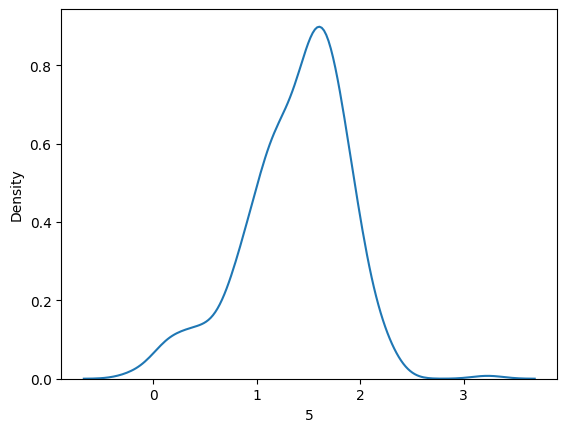

In [46]:
sub = 5
sns.kdeplot(df.loc[sub],legend=False) # seems correctly plotting over subject dimensiopn

In [21]:
# define network atlas & gradients/gradients-rescaled
network_atlas = 'ColeAnticevic'
g1 = np.array(gms_aligned).T  # rescaled?

if network_atlas == 'ColeAnticevic':
    glasser_network_mapping =  glasser_CAatlas_mapping 
    network_names = CAatlas_names
elif network_atlas == 'Yeo17':
    glasser_network_mapping =  glasser_yeo_mapping #
    
    
N_nets = len(np.unique(glasser_network_mapping))

# compute for each subject and for each yeo network a) network centroid position; b) within network dispersion metric (higher value = wider distribution = more dispersion)
centroids_net = []  # center of gravity (median) for given network (i.e., network centroid position) (7 x 1000)
WN_dispersion = []  # Within network dispersion: sum squared Euclidean distance of network nodes to the network centroid at individual level (7 x 1000)


# iterate over the 7 Yeo networks
for n_network in np.unique(glasser_network_mapping):
    
    # identify the nodes of given Yeo network
    netNodes = np.where(glasser_network_mapping == (n_network))[0] # get (glasser space) indices
    netNodes = np.squeeze(netNodes)
    
    # get the gradient loadings of the nodes of the given Yeo network, for each subject (shape: number of nodes in network x N)
    G1_net = g1[netNodes]
    
    ### identify the centroid / center of gravity (= median) of the given Yeo network for each subject (shape: N)
    centroid_cog_net = np.median(G1_net, axis=0)  
    centroids_net.append(centroid_cog_net)
    
    ### within network dispersion: 1 within network dispersion value per subject (per network)
    
    # compute (per subject) the Eucledian distance between each gradient loading (in Yeo network) and that network's centroid
    dist_nodes_to_centroid = G1_net - centroid_cog_net  # shape: number of nodes in network x N
    
    # take the sum of squares of this Eucledian distance 
    sum_of_squares = np.mean((dist_nodes_to_centroid**2), axis = 0)  # shape: N # sum originally!!
    
    # append to list
    WN_dispersion.append(sum_of_squares)
    
centroids_net = np.array(centroids_net)
WN_dispersion = np.array(WN_dispersion)

In [20]:
df = pd.DataFrame(np.array(WN_dispersion.T), index=sub_array, columns = [f"net_{i+1}" for i in range(N_nets)])
df.index.name = 'subject'
df = df.join(group_list).set_index('group',append=True)

#### weird Subjects

for ColeAnticevic
* 51,43 - huge outliers
* 66,4 - small outliers
all group 1 except 66

for Yeo17:
* 50,51,43,66

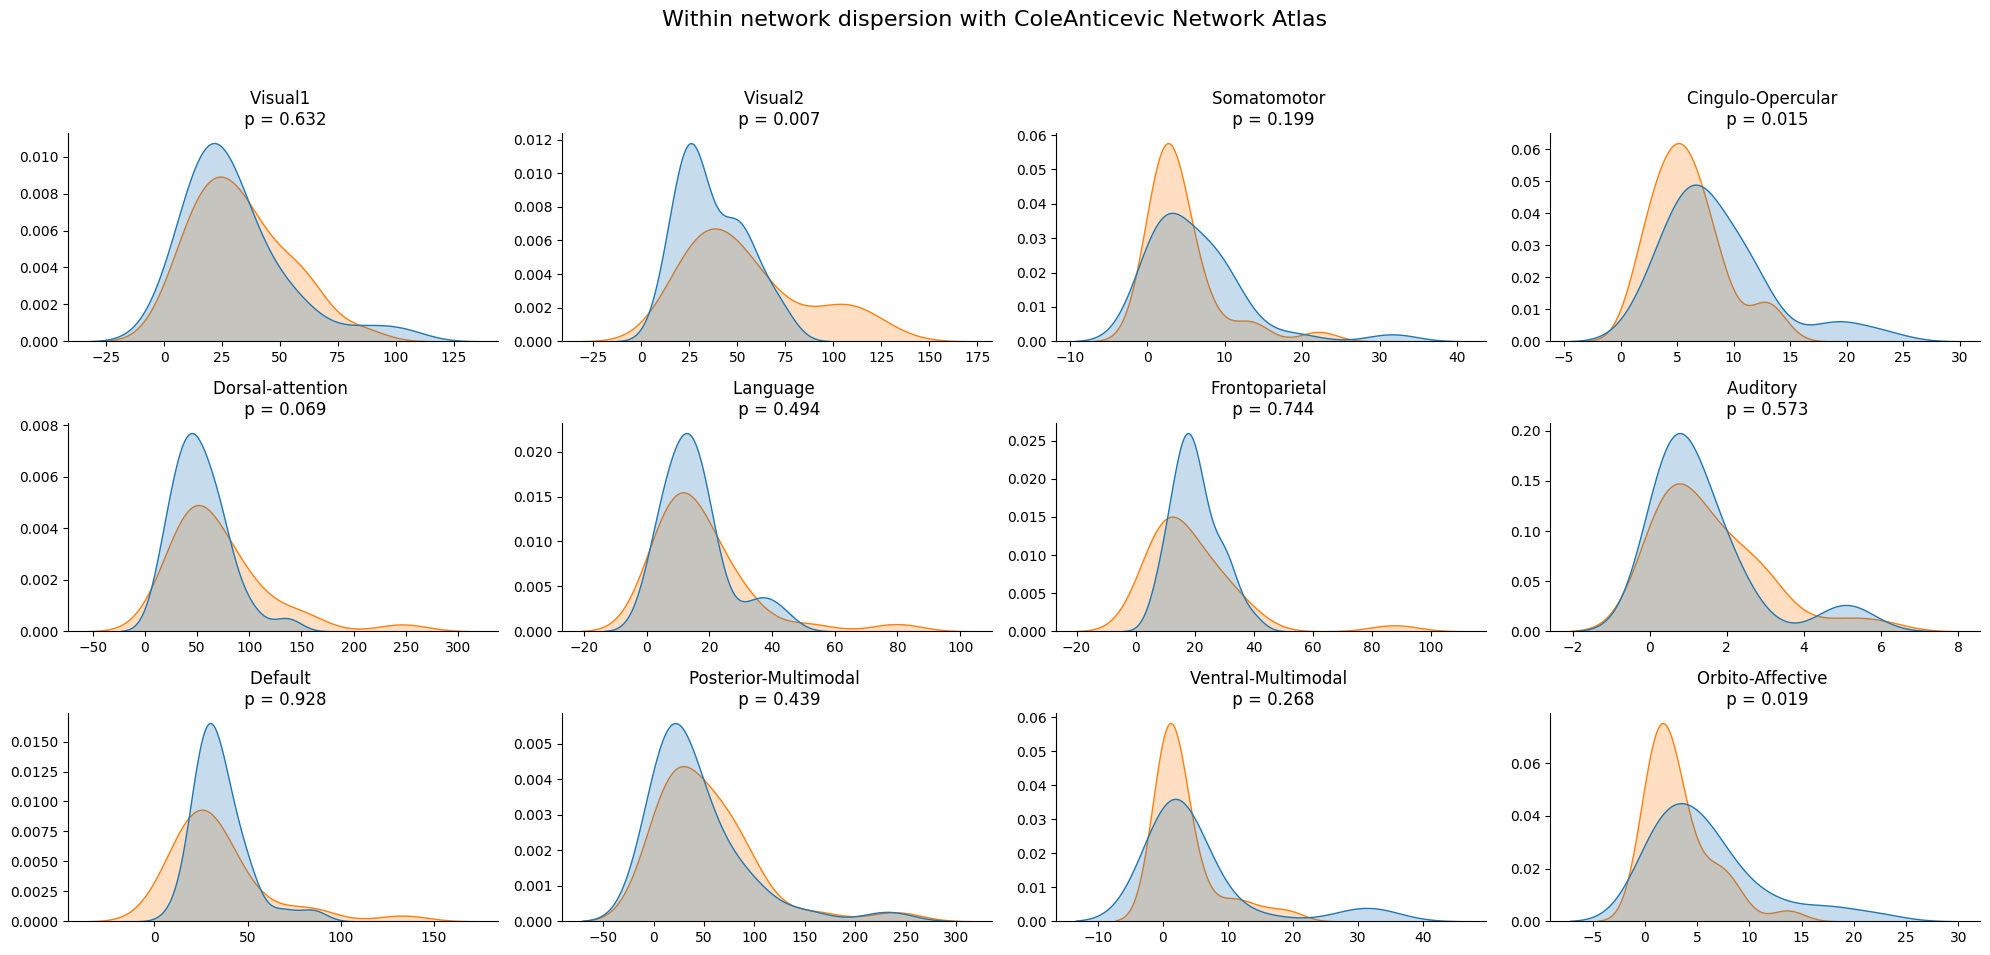

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind


tmp = df.loc[df.mean(axis=1) < 150].reset_index() # remove outlier subjects (weird gradient loading scale due to >1 connected components)
#tmp = df.reset_index()

n_cols = 4  # Number of columns in the subplot grid
n_rows = (N_nets + n_cols - 1) // n_cols  # Calculate rows needed for N_nets subplots

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 10)) # , sharex=True, sharey=True
fig.suptitle(f'Within network dispersion with {network_atlas} Network Atlas', fontsize=16)

for i in range(N_nets):
    ax = axes[i // n_cols, i % n_cols]  # Calculate position in grid
    net_name= network_names.set_index('Label Number').loc[(i+ 1)].item()

    data_net = tmp[f'net_{i + 1}']
    _, p_value = ttest_ind(data_net[tmp['group'] == 0], data_net[tmp['group'] == 1], equal_var=False)  # Welch's t-test
    
    sns.kdeplot(data=tmp, x=f'net_{i + 1}', hue='group', ax=ax, fill=True,legend=False)
    ax.set_title(f'{net_name} \n p = {p_value:.3f}')
    ax.set_xlabel('')
    ax.set_ylabel('')
    #ax.set_xlim(-10,100)
    #ax.set_ylim(0,0.05)

sns.despine()
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Leave space for the suptitle
plt.show()

### visualize regions/parcels/networks on brain surface



In [ ]:
from matplotlib.colors import ListedColormap

cmap_two = ListedColormap(['white', 'darkorchid'], 'custom_colormap')
fsaverage = fetch_surf_fsaverage() # default 5

Text(0.5, 0.98, 'Parcel: PreSubiculum')

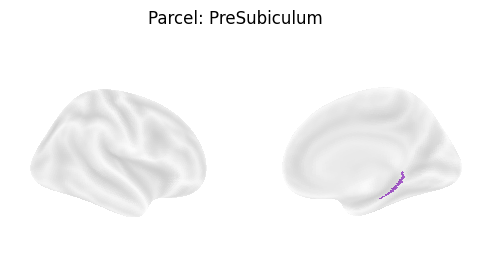

In [180]:
# plot parcel regions
parcel_label = 119
parcel_name = glasser_parcel_names.loc[parcel_label].item()

base_folder='/mnt_03/diverse_neuralData/atlases_parcellations'
space='fsaverage5'
atlas_right =  nib.load(op.join(base_folder,f'rh_space-{space}.HCPMMP1.gii')).agg_data()
glasser_labeling_fsav5 = atlas_right # np.concatenate([atlas_left, atlas_right]) 
map = glasser_labeling_fsav5

map[map != parcel_label] = 0 #np.nan
map[map == parcel_label] = 1

figure, axes = plt.subplots(nrows=1, ncols=2,figsize = (6,3), subplot_kw=dict(projection='3d'))
for i, view in enumerate(['medial','lateral']):
    nplt.plot_surf(surf_mesh= fsaverage.infl_right, surf_map= map, # infl_right # pial_right
                view=view,cmap=cmap_two, colorbar=False, axes=axes[i],
                bg_map=fsaverage.sulc_right, bg_on_data=True,darkness=0.7) #
figure.suptitle(f'Parcel: {parcel_name}')

Text(0.5, 0.98, 'Network: Visual2')

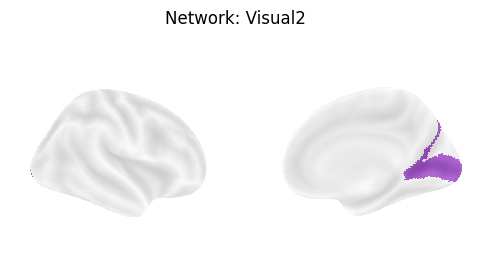

In [181]:
# plot network regions
network_label = 1 # 1-12 !!

net_name= network_names.set_index('Label Number').loc[(network_label+ 1)].item()

caAtlas_fsav5 = map_to_labels(glasser_CAatlas_mapping['ca_network'].values , labeling_glasser, mask=mask_glasser) #, fill=np.nan) #grad_sub[n_grad-1]
map = np.split(caAtlas_fsav5,2)[1].astype(float) # for i, hemi in enumerate(['L', 'R']): --> left first
map[map != network_label] = 0 #np.nan
map[map == network_label] = 1

figure, axes = plt.subplots(nrows=1, ncols=2,figsize = (6,3), subplot_kw=dict(projection='3d'))
for i, view in enumerate(['medial','lateral']):
    nplt.plot_surf(surf_mesh= fsaverage.infl_right, surf_map= map, # infl_right # pial_right
                view=view,cmap=cmap_two, colorbar=False, axes=axes[i],
                bg_map=fsaverage.sulc_right, bg_on_data=True,darkness=0.7) #

figure.suptitle(f'Network: {net_name}')

### Visualize network dispersion in single subjects 
(or group?)

In [ ]:
df_comb = pd.DataFrame(gms_aligned, index=sub_array, columns = [i for i in range(360)]) # f"parcel_{i+1}"
df_comb = df_comb.stack().to_frame().rename(mapper={0:'grad1_loading'},axis=1)
df_comb.index.names = ['subject', 'parcel']

glasser_network_mapping.index.name = 'parcel'
df_comb = df_comb.join(glasser_network_mapping)
df_comb.head()

grad_loading  ca_network
subject parcel                          
21      0          24.801191           1
        1          20.904932           2
        2          18.805656           2
        3          24.501720           2
        4          25.104401           2

/tmp/ipykernel_138266/1525600406.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.legend(handles=handles[1:], labels=new_labels, title='Labels')  # Skip the first handle if it's for the title


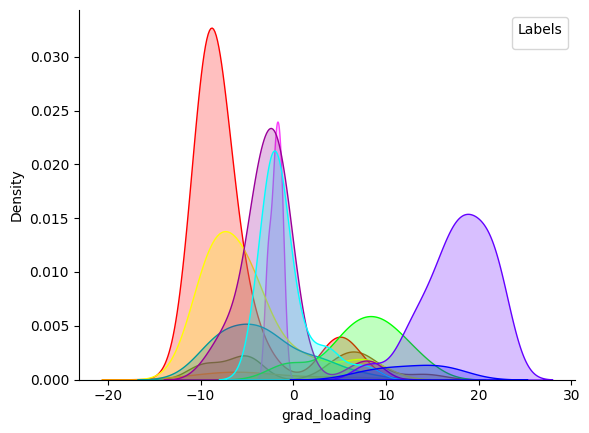

In [ ]:
sub=1
fig = sns.kdeplot(df_comb.xs(sub,0,'subject'),hue='ca_network',x='grad_loading',fill=True,palette=cmap_ca )
sns.despine()

handles, labels = fig.get_legend_handles_labels()
new_labels = [network_names[network_names['Label Number'] == label]['Network Name'] for label in labels[1:]]  # Skip the title label if present

# Update the legend
fig.legend(handles=handles[1:], labels=new_labels, title='Labels')  # Skip the first handle if it's for the title



## Addtional

In [ ]:
## look at weird subs grads

from utils import get_glasser_parcels
from brainspace.utils.parcellation import map_to_labels, reduce_by_labels
mask_glasser, labeling_glasser = get_glasser_parcels(space = 'fsaverage5' )

from  nilearn.datasets import fetch_surf_fsaverage
import nilearn.plotting as nplt
import nibabel as nib
import matplotlib.pyplot as plt


In [ ]:
sub = '43'
n_grad=2
source_folder_gm = op.join(bids_folder,'derivatives','gradients',f'sub-{sub}' )
grad_sub = np.load(op.join(source_folder_gm,f'sub-{sub}_g-aligned_glasserParcel.npy')).T#f'gradients_align-procrustes.npy'))
#grad_sub = np.load(op.join(source_folder_gm,f'sub-{sub}_gradients_glasserParcel.npy')).T#f'gradients_align-procrustes.npy'))

gm_fsav5 = map_to_labels(grad_sub[n_grad-1], labeling_glasser, mask=mask_glasser, fill=np.nan) 
gm_r = np.split(gm_fsav5,2)[1] # for i, hemi in enumerate(['L', 'R']): --> left first

fsaverage = fetch_surf_fsaverage() # default 5
cmap = 'jet'

figure, axes = plt.subplots(nrows=1, ncols=2,figsize = (6,3), subplot_kw=dict(projection='3d'))
for i, view in enumerate(['medial','lateral']):
    nplt.plot_surf(surf_mesh= fsaverage.infl_right, surf_map= gm_r, # infl_right # pial_right
                view=view,cmap=cmap, colorbar=True, axes=axes[i],
                bg_map=fsaverage.sulc_right, bg_on_data=True,darkness=0.7) #
    axes[i].set(title=f'sub-{sub}, grad-{n_grad}')



In [ ]:
# investigate/find origin of weird gradient scale
sub = '01'
source_folder_cm = op.join(bids_folder,'derivatives','correlation_matrices')
space = 'fsaverage'

cm_file = op.join(source_folder_cm,f'sub-{sub}_glasserParcel-{space}.npy')
cm = np.load(cm_file) 

from scipy.sparse.csgraph import connected_components
from nilearn.connectome import ConnectivityMeasure

graph = cm #correlation_measure.fit_transform([seed_ts.T])[0] #correlation_matrix
cc = connected_components(graph) 
mask_cc = cc[1] == 0 # all nodes in 0 belong to the largest connected component, check #-components in cc[0]

print(cc[0])
np.where(cc[1] == 1 ) # 119 for 43,51,66 : PreSubiculum

In [ ]:
# get easier ColeAnticevic network-names label assigment files
import pandas as pd

# Path to your file
file_path =  op.join(datadir,'network_labelfile.txt')

# Initialize lists to store data
network_names = []
label_numbers = []

# Read the file
with open(file_path, 'r') as file:
    lines = file.readlines()
    for i in range(len(lines)):
        # Remove any trailing whitespace
        line = lines[i].strip()
        
        # Check if the line is a network name (not a numeric line)
        if not line[0].isdigit():
            # If so, store it as the network name
            network_name = line
            # Find the next line for the label number
            next_line = lines[i + 1].strip()
            # Get the label number (first number in the line)
            label_number = int(next_line.split()[0])
            # Append the network name and label number to lists
            network_names.append(network_name)
            label_numbers.append(label_number)

# Create a DataFrame from the lists
df = pd.DataFrame({
    'Network Name': network_names,
    'Label Number': label_numbers
})

# Display the table
print(df)
df.to_csv(op.join(datadir,'network_label-names.csv'))
